In [5]:
import torch
from transformers import BertModel, BertTokenizer
import json
import os

# 1. 加载 BERT 模型和 tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 2. 定义一个字典来存储激活值
activations = {}

# 3. 定义钩子函数来捕获特定位置的激活值
def hook_fn(layer_name, target_token_idx):
    def hook(module, input, output):
        # 获取特定token位置的激活值
        # output的形状为 (batch_size, seq_len, hidden_size)
        # 我们选定目标token的位置target_token_idx
        target_activation = output.detach().cpu().numpy()[:, target_token_idx, :]
        activations[layer_name] = target_activation.tolist()
    return hook

# 4. 注册钩子：遍历所有 Transformer 层并注册钩子
hooks = []
input_text = "Hello, how are you?"

# 5. 将输入文本转换为token，并获取目标token的位置（如[CLS]或某个token）
inputs = tokenizer(input_text, return_tensors="pt")
tokens = tokenizer.tokenize(input_text)

# 假设我们想要获取第一个token（[CLS]）的位置
target_token_idx = 0  # [CLS]通常是第一个token

# 6. 注册钩子到每一层的 intermediate.dense（FFN部分）
for i, layer in enumerate(model.encoder.layer):
    hook = layer.intermediate.dense.register_forward_hook(hook_fn(f"layer_{i}_ffn", target_token_idx))
    hooks.append(hook)

# 7. 执行前向传播
outputs = model(**inputs)

# 8. 保存激活值到硬盘（保存为 JSON 格式）
save_dir = "./activations"
os.makedirs(save_dir, exist_ok=True)

# 保存路径
activation_file_path = os.path.join(save_dir, "activations.json")

# 将激活值字典保存为 JSON 文件
with open(activation_file_path, 'w') as json_file:
    json.dump(activations, json_file)

print(f"Activations saved to {activation_file_path}")

# 9. 移除钩子
for hook in hooks:
    hook.remove()


Activations saved to ./activations/activations.json


In [ ]:
# from datasets import load_dataset
# ds = load_dataset("coastalcph/lex_glue", "ecthr_a", cache_dir="/cache/huggingface/datasets")
from datasets import load_dataset

ds = load_dataset("codyburker/yelp_review_sampled", cache_dir="/cache/huggingface/datasets")
# ds = load_dataset("Yelp/yelp_review_full", cache_dir="/cache/huggingface/datasets")

# ds = load_dataset("bookcorpus/bookcorpus", cache_dir="/cache/huggingface/datasets")
# ds = load_dataset("bookcorpus/bookcorpus", cache_dir="/cache/huggingface/datasets")

Generating test split: 100%|██████████| 50000/50000 [00:00<00:00, 145301.66 examples/s]


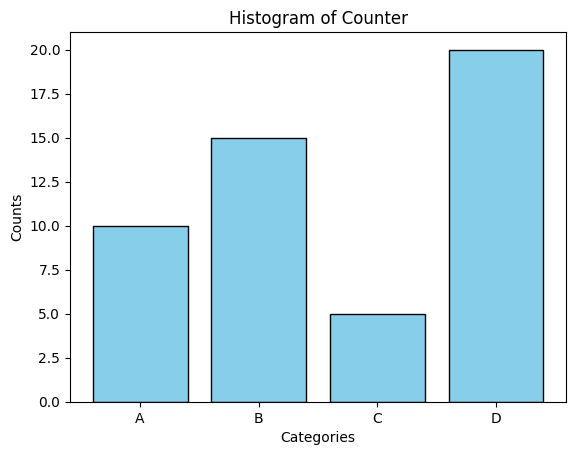

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

# 示例 Counter 对象
data = Counter({'A': 10, 'B': 15, 'C': 5, 'D': 20})

# 绘制直方图
def plot_counter_histogram(counter_obj):
    labels = list(counter_obj.keys())
    values = list(counter_obj.values())

    plt.bar(labels, values, color='skyblue', edgecolor='black')
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Histogram of Counter')
    plt.show()

# 调用函数绘制
plot_counter_histogram(data)

In [4]:
import torch
import torch.nn as nn

# 创建一个 Linear 层
linear = nn.Linear(in_features=10, out_features=5)

# 初始化输入
x = torch.randn(1, 10)

# 前向计算
output = linear(x)

# 钩子函数：仅保留第 i 个神经元的梯度
i = 2
def hook_fn(grad):
    mask = torch.zeros_like(grad)
    mask[i, :] = 1  # 仅保留第 i 行的梯度
    return grad * mask

linear.weight.register_hook(hook_fn)

# 损失函数
loss = output.sum()

# 反向传播
loss.backward()

# 查看梯度
print(linear.weight.grad)


tensor([[ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.7593, -0.1422, -0.8351, -0.6397, -0.1545, -1.1371, -0.7905,  0.8253,
          1.0648,  0.4474],
        [ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000]])
